# Dataset Exploration

In [89]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from copy import deepcopy
from rich import inspect
from tqdm import tqdm

# torch
import torch

# monai
import monai
from monai.data import ImageDataset, ThreadDataLoader


In [90]:
# rtk
from rtk import repl
from rtk.config import (
    set_hydra_configuration,
    Configuration,
    DatasetConfiguration,
    JobConfiguration,
)
from rtk.utils import login, hydra_instantiate, get_console, get_logger


In [91]:
repl.install(show_locals=False)
console = get_console()
logger = get_logger("rtk.notebook")
monai.config.print_config()

MONAI version: 1.3.0
Numpy version: 1.23.5
Pytorch version: 2.1.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/anaconda3/envs/rtk/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.13
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.22.0
scipy version: 1.11.3
Pillow version: 10.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.0+cu121
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.1.2
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.8.0
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    ht

### Constant setup

In [92]:
# configs
config_name = "tests"
config_path = "../configs/"
config_dir = os.path.abspath(config_path)
config_dir

'/home/nicoleg/workspaces/ResearchToolKit/configs'

In [93]:
cfg: Configuration = set_hydra_configuration(
        config_name=config_name,
        init_method_kwargs={"config_dir": config_dir},
        ConfigurationInstance=Configuration,
    )
dataset_cfg: DatasetConfiguration = cfg.datasets
job_cfg: JobConfiguration = cfg.job
monai.utils.set_determinism(seed=job_cfg.random_state)
cfg

[17:14:57] INFO     rtk.config: Creating configuration: 'tests'                                       ]8;id=288389;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/config.py\config.py]8;;\:]8;id=256787;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/config.py#292\292]8;;\
                    [0m                                                                                            

Configuration(
    date='2023-11-07',
    postfix='',
    timestamp='17-14-57',
    datasets={'dim': 229, 'extension': '.png', 'index': 'Image Index', 'labels': ['Non-Pneumonia', 'Pneumonia'], 'target': 'Finding Labels', 'patient_data': '/home/nicoleg/workspaces/dissertation/.data/Chest_XRay_14_Kaggle_RGB/Data_Entry_2017.csv', 'scan_data': '/home/nicoleg/workspaces/dissertation/.data/Chest_XRay_14_Kaggle_RGB/', 'encoding': {'Non-Pneumonia': 0, 'Pneumonia': 1}, 'instantiate': {'_target_': 'monai.data.ImageDataset'}, 'dataloader': {'_target_': 'monai.data.ThreadDataLoader', 'batch_size': 16, 'num_workers': 24}, 'preprocessing': {'positive_class': 'Pneumonia', 'subset': ['Atelectasis', 'Edema', 'Effusion', 'Consolidation', 'Pneumonia'], 'use_sampling': True, 'sampling_method': {'sample_to_value': 5000, 'method': {'_partial_': True, '_target_': 'imblearn.datasets.make_imbalance', 'verbose': True}}}, 'transforms': {'load': [{'_target_': 'monai.transforms.ScaleIntensity'}, {'_target_': 'monai.transforms.EnsureChannelFirst'}, {'_target_': 'monai.transforms.EnsureType', 'track_meta': True}, {'_target_': 'monai.transforms.Resize', 'spatial_size': ['${datasets.dim}', '${datasets.dim}']}], 'train': [{'_target_': 'torchvision.transforms.RandomResizedCrop', 'scale': [0.75, 1.25], 'size': ['${datasets.dim}', '${datasets.dim}'], 'antialias': True}, {'_target_': 'torchvision.transforms.RandomAffine', 'degrees': 45, 'shear': 16, 'translate': [0.15, 0.2]}]}},
    job={'device': 1, 'dry_run': True, 'epoch_length': 8, 'max_epochs': 2, 'mode': 'train', 'perform_validation': True, 'random_state': 42, 'set_track_meta': False, 'use_autocast': True, 'use_azureml': True, 'use_mlflow': True, 'use_pretrained': True, 'use_transforms': True, 'train_test_split': {'shuffle': True, 'test_size': 0.1}, 'prepare_function': {'_target_': 'rtk.ignite.prepare_run'}, 'tags': {'type': 'test'}},
    models={'model': {'_target_': 'timm.create_model', 'model_name': 'resnet50', 'num_classes': 2, 'pretrained': '${job.use_pretrained}'}, 'load_model': {'name': 'resnet50_PEDIATRICS_CHESTXRAY14', 'version': 1}, 'criterion': {'_target_': 'torch.nn.CrossEntropyLoss'}, 'optimizer': {'_target_': 'torch.optim.Adam', 'lr': 1e-05, 'weight_decay': 0.01}},
    ignite={'log_interval': 5, 'score_name': 'loss', 'use_checkpoint': True, 'use_early_stopping': True, 'use_lr_scheduler': False, 'use_multi_gpu': False, 'metrics': {'Accuracy': None, 'Loss': None, 'Predictions': None}, 'checkpoint': {'_target_': 'ignite.handlers.checkpoint.Checkpoint', 'save_handler': 'artifacts/checkpoints/', 'filename_prefix': 'best', 'n_saved': 10}, 'early_stopping': {'_target_': 'ignite.handlers.early_stopping.EarlyStopping', 'patience': 5}, 'lr_scheduler': None},
    mlflow={'tracking_uri': 'file:///mlruns/'},
    sklearn={'model_selection': {'train_test_split': {'shuffle': True, 'test_size': 0.1}}}
)

In [94]:
patient_path = dataset_cfg.patient_data
patient_path

'/home/nicoleg/workspaces/dissertation/.data/Chest_XRay_14_Kaggle_RGB/Data_Entry_2017.csv'

In [95]:
scan_path = "/home/nicoleg/workspaces/dissertation/.data/Chest_XRay_14_Kaggle/"
scan_path

'/home/nicoleg/workspaces/dissertation/.data/Chest_XRay_14_Kaggle/'

# Exploration

In [96]:
# https://stackoverflow.com/questions/339007/how-do-i-pad-a-string-with-zeroes
index = dataset_cfg.index
target = dataset_cfg.target
label_encoding = 1
patient_df = pd.read_csv(patient_path).set_index(index)
label_path = os.path.join(scan_path, f"images_{label_encoding:03}", "images")
os.listdir(label_path)


[
    '00000096_001.png',
    '00001250_005.png',
    '00001220_000.png',
    '00000419_000.png',
    '00000654_001.png',
    '00000827_016.png',
    '00000468_025.png',
    ... +4992
]

In [97]:
# subset to the indicated indices in the label encoding
filename_matches = {"image_files": [], index: []}

for filename in os.listdir(label_path):
    filename_matches[index].append(filename)
    filename_matches["image_files"].append(os.path.join(label_path, filename))

filename_matches


{
    'image_files': [
        '/home/nicoleg/workspaces/dissertation/.data/Chest_XRay_14_Kaggle/images_001/images/00000096_001.png',
        '/home/nicoleg/workspaces/dissertation/.data/Chest_XRay_14_Kaggle/images_001/images/00001250_005.png',
        '/home/nicoleg/workspaces/dissertation/.data/Chest_XRay_14_Kaggle/images_001/images/00001220_000.png',
        '/home/nicoleg/workspaces/dissertation/.data/Chest_XRay_14_Kaggle/images_001/images/00000419_000.png',
        '/home/nicoleg/workspaces/dissertation/.data/Chest_XRay_14_Kaggle/images_001/images/00000654_001.png',
        '/home/nicoleg/workspaces/dissertation/.data/Chest_XRay_14_Kaggle/images_001/images/00000827_016.png',
        '/home/nicoleg/workspaces/dissertation/.data/Chest_XRay_14_Kaggle/images_001/images/00000468_025.png',
        ... +4992
    ],
    'Image Index': [
        '00000096_001.png',
        '00001250_005.png',
        '00001220_000.png',
        '00000419_000.png',
        '00000654_001.png',
        '00000827_016.png',
        '00000468_025.png',
        ... +4992
    ]
}

## Wrangling data

In [98]:
patient_df.head()

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
Image Index,,,,,,,,,,
00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


In [99]:
# drop unnecessary columns

drop_columns = [
    "Follow-up #",
    "OriginalImage[Width",
    "Height]",
    "OriginalImagePixelSpacing[x",
    "y]",
    "View Position",
]
patient_df = patient_df.drop(columns=drop_columns)
patient_df.head()

,Finding Labels,Patient ID,Patient Age,Patient Gender
Image Index,,,,
00000001_000.png,Cardiomegaly,1,58,M
00000001_001.png,Cardiomegaly|Emphysema,1,58,M
00000001_002.png,Cardiomegaly|Effusion,1,58,M
00000002_000.png,No Finding,2,81,M
00000003_000.png,Hernia,3,81,F


In [100]:
def unpack_images():
    """"""

    filename_matches = {"image_files": [], index: []}

    for encoding in range(1, 13):
        label_path = os.path.join(scan_path, f"images_{encoding:03}", "images")

        for filename in os.listdir(label_path):
            filename_matches[index].append(filename)
            filename_matches["image_files"].append(os.path.join(label_path, filename))

    return pd.DataFrame.from_dict(filename_matches, orient="columns").set_index(index)

matches = unpack_images()
len(matches), matches.head()

(
    112120,
                                                            image_files
Image Index                                                        
00000096_001.png  /home/nicoleg/workspaces/dissertation/.data/Ch...
00001250_005.png  /home/nicoleg/workspaces/dissertation/.data/Ch...
00001220_000.png  /home/nicoleg/workspaces/dissertation/.data/Ch...
00000419_000.png  /home/nicoleg/workspaces/dissertation/.data/Ch...
00000654_001.png  /home/nicoleg/workspaces/dissertation/.data/Ch...
)

In [101]:
patient_df = patient_df.merge(matches, on=index, how="inner")
patient_df.head()

,Finding Labels,Patient ID,Patient Age,Patient Gender,image_files
Image Index,,,,,
00000001_000.png,Cardiomegaly,1,58,M,/home/nicoleg/workspaces/dissertation/.data/Ch...
00000001_001.png,Cardiomegaly|Emphysema,1,58,M,/home/nicoleg/workspaces/dissertation/.data/Ch...
00000001_002.png,Cardiomegaly|Effusion,1,58,M,/home/nicoleg/workspaces/dissertation/.data/Ch...
00000002_000.png,No Finding,2,81,M,/home/nicoleg/workspaces/dissertation/.data/Ch...
00000003_000.png,Hernia,3,81,F,/home/nicoleg/workspaces/dissertation/.data/Ch...


In [102]:
with open(os.path.join(scan_path, "train_val_list.txt"), "r") as f:
    train_val_list = f.readlines()

train_val_list

[
    '00000001_000.png\n',
    '00000001_001.png\n',
    '00000001_002.png\n',
    '00000002_000.png\n',
    '00000004_000.png\n',
    '00000005_000.png\n',
    '00000005_001.png\n',
    ... +86517
]

In [103]:
train_val_list = [idx.strip() for idx in train_val_list]
train_val_list

[
    '00000001_000.png',
    '00000001_001.png',
    '00000001_002.png',
    '00000002_000.png',
    '00000004_000.png',
    '00000005_000.png',
    '00000005_001.png',
    ... +86517
]

In [104]:
# do the same for the test list
with open(os.path.join(scan_path, "test_list.txt"), "r") as f:
    test_list = f.readlines()
    test_list = [idx.strip() for idx in test_list]

test_list

[
    '00000003_000.png',
    '00000003_001.png',
    '00000003_002.png',
    '00000003_003.png',
    '00000003_004.png',
    '00000003_005.png',
    '00000003_006.png',
    ... +25589
]

In [105]:
train_df = patient_df[patient_df.index.isin(train_val_list)]
train_df.head()

,Finding Labels,Patient ID,Patient Age,Patient Gender,image_files
Image Index,,,,,
00000001_000.png,Cardiomegaly,1,58,M,/home/nicoleg/workspaces/dissertation/.data/Ch...
00000001_001.png,Cardiomegaly|Emphysema,1,58,M,/home/nicoleg/workspaces/dissertation/.data/Ch...
00000001_002.png,Cardiomegaly|Effusion,1,58,M,/home/nicoleg/workspaces/dissertation/.data/Ch...
00000002_000.png,No Finding,2,81,M,/home/nicoleg/workspaces/dissertation/.data/Ch...
00000004_000.png,Mass|Nodule,4,82,M,/home/nicoleg/workspaces/dissertation/.data/Ch...


In [106]:
test_df = patient_df[patient_df.index.isin(test_list)]
test_df.head()

,Finding Labels,Patient ID,Patient Age,Patient Gender,image_files
Image Index,,,,,
00000003_000.png,Hernia,3,81,F,/home/nicoleg/workspaces/dissertation/.data/Ch...
00000003_001.png,Hernia,3,74,F,/home/nicoleg/workspaces/dissertation/.data/Ch...
00000003_002.png,Hernia,3,75,F,/home/nicoleg/workspaces/dissertation/.data/Ch...
00000003_003.png,Hernia|Infiltration,3,76,F,/home/nicoleg/workspaces/dissertation/.data/Ch...
00000003_004.png,Hernia,3,77,F,/home/nicoleg/workspaces/dissertation/.data/Ch...


## Pneumonia to metaclass

In [107]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

In [108]:
# subsetting
# all_labels = dataset_cfg.all_labels
labels = dataset_cfg.labels
positive_class = dataset_cfg.preprocessing["positive_class"]
console.print(f"Positive class: '{positive_class}'")
console.print(f"New labels:\n{labels}")

Positive class: 'Pneumonia'

New labels:
['Non-Pneumonia', 'Pneumonia']

In [109]:
# unique

console.print("Data description:")
console.print(patient_df[target].nunique())
patient_target_counts = Counter(patient_df[target])
patient_target_counts

Data description:

836

Counter({
    'Cardiomegaly': 1093,
    'Cardiomegaly|Emphysema': 19,
    'Cardiomegaly|Effusion': 484,
    'No Finding': 60361,
    'Hernia': 110,
    'Hernia|Infiltration': 15,
    'Mass|Nodule': 394,
    ... +829
})

In [110]:
temp = list(patient_target_counts.keys())[:10]
for key in temp:
    classes = key.split("|")
    console.print(classes)

['Cardiomegaly']

['Cardiomegaly', 'Emphysema']

['Cardiomegaly', 'Effusion']

['No Finding']

['Hernia']

['Hernia', 'Infiltration']

['Mass', 'Nodule']

['Infiltration']

['Effusion', 'Infiltration']

['Nodule']

In [111]:
multi_target = f"multi_{target}"
patient_df[multi_target] = patient_df[target].apply(lambda x: x.split("|"))
patient_df[multi_target]

Image Index
00000001_000.png               [Cardiomegaly]
00000001_001.png    [Cardiomegaly, Emphysema]
00000001_002.png     [Cardiomegaly, Effusion]
00000002_000.png                 [No Finding]
00000003_000.png                     [Hernia]
                              ...            
00030801_001.png            [Mass, Pneumonia]
00030802_000.png                 [No Finding]
00030803_000.png                 [No Finding]
00030804_000.png                 [No Finding]
00030805_000.png                 [No Finding]
Name: multi_Finding Labels, Length: 112120, dtype: object

In [112]:
mlb.fit(patient_df[multi_target])
mlb.classes_

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype=object)

In [113]:
class_encoding = {label: i for i, label in enumerate(mlb.classes_)}
console.print(class_encoding)

{
    'Atelectasis': 0,
    'Cardiomegaly': 1,
    'Consolidation': 2,
    'Edema': 3,
    'Effusion': 4,
    'Emphysema': 5,
    'Fibrosis': 6,
    'Hernia': 7,
    'Infiltration': 8,
    'Mass': 9,
    'No Finding': 10,
    'Nodule': 11,
    'Pleural_Thickening': 12,
    'Pneumonia': 13,
    'Pneumothorax': 14
}

In [114]:
for row in patient_df[multi_target][:10]:
    row = [row]
    console.print(mlb.transform(row)[0])

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]

[0 1 0 0 0 1 0 0 0 0 0 0 0 0 0]

[0 1 0 0 1 0 0 0 0 0 0 0 0 0 0]

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]

[0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]

## New multi-index

In [116]:
# def build_bitstring(
#     target: str, df: pd.DataFrame, mlb: MultiLabelBinarizer, inplace=False
# ):
#     logger.info(f"Building bitstring for '{target}'")

#     def __bool_list_to_bitstring(x):
#         x = mlb.transform([x])[0]
#         return x

#     transform = df[target].apply(lambda x: __bool_list_to_bitstring(x))
#     if inplace:
#         df[target] = transform
#     else:
#         return transform


def build_multiclass_dataframe(cfg: Configuration, df: pd.DataFrame, **kwargs):
    """"""
    dataset_cfg = kwargs.get("dataset_cfg", cfg.datasets)

    mlb = MultiLabelBinarizer()
    labels = dataset_cfg.labels
    positive_class = dataset_cfg.preprocessing["positive_class"]
    console.print(f"Positive class: '{positive_class}'")
    console.print(f"New labels:\n{labels}")
    logger.debug(f"{Counter(df[target])}")

    multi_target = f"multi_{target}"
    patient_df[multi_target] = patient_df[target].apply(lambda x: x.split("|"))
    mlb.fit(df[multi_target])
    class_encoding = {label: i for i, label in enumerate(mlb.classes_)}
    console.print(f"Dataset class encoding:\n{class_encoding}")

    _transforms = df[multi_target].apply(lambda x: mlb.transform([x])[0])
    multiclass_df = pd.DataFrame.from_records(
        _transforms, index=df.index, columns=mlb.classes_
    )

    return multiclass_df, class_encoding


multiclass_df, class_encoding = build_multiclass_dataframe(cfg, patient_df)
multiclass_df.head()

Positive class: 'Pneumonia'

New labels:
['Non-Pneumonia', 'Pneumonia']

Dataset class encoding:
{'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 2, 'Edema': 3, 'Effusion': 4, 'Emphysema': 5, 'Fibrosis': 6,
'Hernia': 7, 'Infiltration': 8, 'Mass': 9, 'No Finding': 10, 'Nodule': 11, 'Pleural_Thickening': 12, 'Pneumonia': 
13, 'Pneumothorax': 14}

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Image Index,,,,,,,,,,,,,,,
00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
00000002_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


#### Individual class counts using multi-index table

In [117]:
for column in multiclass_df.columns:
    console.print(f"'{column} ({class_encoding[column]})': {Counter(multiclass_df[column])}")

'Atelectasis (0)': Counter({0: 100561, 1: 11559})

'Cardiomegaly (1)': Counter({0: 109344, 1: 2776})

'Consolidation (2)': Counter({0: 107453, 1: 4667})

'Edema (3)': Counter({0: 109817, 1: 2303})

'Effusion (4)': Counter({0: 98803, 1: 13317})

'Emphysema (5)': Counter({0: 109604, 1: 2516})

'Fibrosis (6)': Counter({0: 110434, 1: 1686})

'Hernia (7)': Counter({0: 111893, 1: 227})

'Infiltration (8)': Counter({0: 92226, 1: 19894})

'Mass (9)': Counter({0: 106338, 1: 5782})

'No Finding (10)': Counter({1: 60361, 0: 51759})

'Nodule (11)': Counter({0: 105789, 1: 6331})

'Pleural_Thickening (12)': Counter({0: 108735, 1: 3385})

'Pneumonia (13)': Counter({0: 110689, 1: 1431})

'Pneumothorax (14)': Counter({0: 106818, 1: 5302})

#### Data split version 1.0: subset to any sample that contains the positive class

In [121]:
pneumonia_df = multiclass_df[multiclass_df["Pneumonia"] == 1]
pneumonia_df["labels"] = pd.Series(np.ones(len(pneumonia_df), dtype=int), index=pneumonia_df.index)
pneumonia_df.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,labels
Image Index,,,,,,,,,,,,,,,,
00000013_010.png,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1
00000032_012.png,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1
00000056_000.png,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
00000061_012.png,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0,1
00000061_015.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [122]:
non_pneumonia_df = multiclass_df.drop(pneumonia_df.index)
non_pneumonia_df["labels"] = pd.Series(np.zeros(len(non_pneumonia_df), dtype=int), index=non_pneumonia_df.index)
non_pneumonia_df

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,labels
Image Index,,,,,,,,,,,,,,,,
00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
00000002_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00030801_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
00030802_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
00030803_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [123]:
console.print(f"Number of pneumonia cases: {len(pneumonia_df)}, {len(pneumonia_df) / len(multiclass_df) * 100:.4f}%")
console.print(f"Number of non-pneumonia cases: {len(non_pneumonia_df)}, {len(non_pneumonia_df) / len(multiclass_df) * 100:.4f}%")
assert len(multiclass_df) == len(pneumonia_df) + len(non_pneumonia_df)

Number of pneumonia cases: 1431, 1.2763%

Number of non-pneumonia cases: 110689, 98.7237%

In [124]:
multiclassv1_df = pd.concat([pneumonia_df, non_pneumonia_df])
assert len(multiclassv1_df) == len(pneumonia_df) + len(non_pneumonia_df)
v1_labels = multiclassv1_df["labels"]
multiclassv1_df

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,labels
Image Index,,,,,,,,,,,,,,,,
00000013_010.png,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1
00000032_012.png,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1
00000056_000.png,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
00000061_012.png,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0,1
00000061_015.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00030801_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
00030802_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
00030803_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


#### Data split version 2.0: subset to samples ONLY containing the positive class

In [125]:
non_pneumonia_columns = list(set(multiclass_df.columns) - set(["Pneumonia"]))
console.print(non_pneumonia_columns)

[
    'Mass',
    'Nodule',
    'No Finding',
    'Effusion',
    'Pneumothorax',
    'Consolidation',
    'Infiltration',
    'Pleural_Thickening',
    'Fibrosis',
    'Emphysema',
    'Cardiomegaly',
    'Hernia',
    'Atelectasis',
    'Edema'
]

In [126]:
_drop_indices = []

for column in non_pneumonia_columns:
    _drop_indices.extend(list(pneumonia_df[pneumonia_df[column] == 1].index))

drop_indices = pd.Index(_drop_indices)
drop_indices

Index(['00001582_017.png', '00001836_110.png', '00004074_000.png',
       '00004532_001.png', '00005288_014.png', '00005619_000.png',
       '00005712_011.png', '00007354_027.png', '00008154_000.png',
       '00008230_000.png',
       ...
       '00029431_000.png', '00029469_012.png', '00029654_000.png',
       '00029861_012.png', '00029861_013.png', '00029883_006.png',
       '00030079_066.png', '00030079_067.png', '00030152_000.png',
       '00030570_001.png'],
      dtype='object', length=1907)

In [127]:
pneumonia_df = pneumonia_df.drop(index=drop_indices)
pneumonia_df


,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,labels
Image Index,,,,,,,,,,,,,,,,
00000061_015.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
00000144_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
00000165_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
00000193_019.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
00000218_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00028924_005.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
00029481_004.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
00029889_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


The Non-Pneumonia class stays the same for both versions.

In [128]:
non_pneumonia_df

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,labels
Image Index,,,,,,,,,,,,,,,,
00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
00000002_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00030801_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
00030802_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
00030803_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [129]:
VERSION_2_TOTAL = 111011
console.print(f"Number of pneumonia cases: {len(pneumonia_df)}, {len(pneumonia_df) / len(multiclass_df) * 100:.4f}%")
console.print(f"Number of non-pneumonia cases: {len(non_pneumonia_df)}, {len(non_pneumonia_df) / len(multiclass_df) * 100:.4f}%")
assert len(pneumonia_df) + len(non_pneumonia_df) == VERSION_2_TOTAL

Number of pneumonia cases: 322, 0.2872%

Number of non-pneumonia cases: 110689, 98.7237%

In [130]:
multiclassv2_df = pd.concat([pneumonia_df, non_pneumonia_df])
assert len(multiclassv2_df) == len(pneumonia_df) + len(non_pneumonia_df)
v2_labels = multiclassv2_df["labels"]
multiclassv2_df.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,labels
Image Index,,,,,,,,,,,,,,,,
00000061_015.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
00000144_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
00000165_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
00000193_019.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
00000218_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


### We can form train and test splits now

#### Version 1.0

In [131]:
v1_patient_df = patient_df.loc[multiclassv1_df.index]
v1_patient_df = pd.concat([v1_patient_df, multiclassv1_df['labels']], axis=1)
v1_train_df = v1_patient_df[v1_patient_df.index.isin(train_val_list)]
v1_train_df

,Finding Labels,Patient ID,Patient Age,Patient Gender,image_files,multi_Finding Labels,labels
Image Index,,,,,,,
00000056_000.png,Nodule|Pneumonia,56,76,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,"[Nodule, Pneumonia]",1
00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,61,77,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,"[Edema, Effusion, Infiltration, Pleural_Thicke...",1
00000061_015.png,Pneumonia,61,77,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Pneumonia],1
00000144_001.png,Pneumonia,144,83,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Pneumonia],1
00000165_001.png,Pneumonia,165,76,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Pneumonia],1
...,...,...,...,...,...,...,...
00030786_007.png,Consolidation|Pleural_Thickening,30786,61,F,/home/nicoleg/workspaces/dissertation/.data/Ch...,"[Consolidation, Pleural_Thickening]",0
00030789_000.png,Infiltration,30789,52,F,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Infiltration],0
00030793_000.png,Mass|Nodule,30793,58,F,/home/nicoleg/workspaces/dissertation/.data/Ch...,"[Mass, Nodule]",0


In [132]:
v1_test_df = v1_patient_df[v1_patient_df.index.isin(test_list)]
v1_test_df

,Finding Labels,Patient ID,Patient Age,Patient Gender,image_files,multi_Finding Labels,labels
Image Index,,,,,,,
00000013_010.png,Effusion|Pneumonia|Pneumothorax,13,60,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,"[Effusion, Pneumonia, Pneumothorax]",1
00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,32,55,F,/home/nicoleg/workspaces/dissertation/.data/Ch...,"[Atelectasis, Consolidation, Edema, Pneumonia]",1
00000150_002.png,Atelectasis|Infiltration|Pneumonia,150,55,F,/home/nicoleg/workspaces/dissertation/.data/Ch...,"[Atelectasis, Infiltration, Pneumonia]",1
00000193_019.png,Pneumonia,193,55,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Pneumonia],1
00000211_013.png,Cardiomegaly|Edema|Effusion|Infiltration|Pneum...,211,59,F,/home/nicoleg/workspaces/dissertation/.data/Ch...,"[Cardiomegaly, Edema, Effusion, Infiltration, ...",1
...,...,...,...,...,...,...,...
00030800_000.png,No Finding,30800,34,F,/home/nicoleg/workspaces/dissertation/.data/Ch...,[No Finding],0
00030802_000.png,No Finding,30802,29,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[No Finding],0
00030803_000.png,No Finding,30803,42,F,/home/nicoleg/workspaces/dissertation/.data/Ch...,[No Finding],0


In [133]:
console.print(f"Number in 'train_val_list' cases: {len(v1_train_df)}, {len(v1_train_df) / len(v1_patient_df) * 100:.4f}%")
console.print(f"Number of occurrences for 'Pneumonia' class 'train_val_list.txt:'\n{Counter(v1_train_df['labels'])}")
console.print(f"Number in 'test_list' cases: {len(v1_test_df)}, {len(v1_test_df) / len(v1_patient_df) * 100:.4f}%")
console.print(f"Number of occurrences for 'Pneumonia' class 'test_list.txt:'\n{Counter(v1_test_df['labels'])}")
assert len(v1_train_df) + len(v1_test_df) == len(v1_patient_df)

Number in 'train_val_list' cases: 86524, 77.1709%

Number of occurrences for 'Pneumonia' class 'train_val_list.txt:'
Counter({0: 85648, 1: 876})

Number in 'test_list' cases: 25596, 22.8291%

Number of occurrences for 'Pneumonia' class 'test_list.txt:'
Counter({0: 25041, 1: 555})

#### Version 2.0

In [134]:
v2_patient_df = patient_df.loc[multiclassv2_df.index]
v2_patient_df = pd.concat([v2_patient_df, multiclassv2_df['labels']], axis=1)
v2_train_df = v2_patient_df[v2_patient_df.index.isin(train_val_list)]
v2_train_df

,Finding Labels,Patient ID,Patient Age,Patient Gender,image_files,multi_Finding Labels,labels
Image Index,,,,,,,
00000061_015.png,Pneumonia,61,77,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Pneumonia],1
00000144_001.png,Pneumonia,144,83,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Pneumonia],1
00000165_001.png,Pneumonia,165,76,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Pneumonia],1
00000261_002.png,Pneumonia,261,40,F,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Pneumonia],1
00000310_001.png,Pneumonia,310,60,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Pneumonia],1
...,...,...,...,...,...,...,...
00030786_007.png,Consolidation|Pleural_Thickening,30786,61,F,/home/nicoleg/workspaces/dissertation/.data/Ch...,"[Consolidation, Pleural_Thickening]",0
00030789_000.png,Infiltration,30789,52,F,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Infiltration],0
00030793_000.png,Mass|Nodule,30793,58,F,/home/nicoleg/workspaces/dissertation/.data/Ch...,"[Mass, Nodule]",0


In [135]:
v2_test_df = v2_patient_df[v2_patient_df.index.isin(test_list)]
v2_test_df

,Finding Labels,Patient ID,Patient Age,Patient Gender,image_files,multi_Finding Labels,labels
Image Index,,,,,,,
00000193_019.png,Pneumonia,193,55,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Pneumonia],1
00000218_001.png,Pneumonia,218,33,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Pneumonia],1
00000583_045.png,Pneumonia,583,40,F,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Pneumonia],1
00001247_011.png,Pneumonia,1247,44,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Pneumonia],1
00001437_019.png,Pneumonia,1437,30,F,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Pneumonia],1
...,...,...,...,...,...,...,...
00030800_000.png,No Finding,30800,34,F,/home/nicoleg/workspaces/dissertation/.data/Ch...,[No Finding],0
00030802_000.png,No Finding,30802,29,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[No Finding],0
00030803_000.png,No Finding,30803,42,F,/home/nicoleg/workspaces/dissertation/.data/Ch...,[No Finding],0


In [136]:
console.print(f"Number in 'train_val_list' cases: {len(v2_train_df)}, {len(v2_train_df) / len(v2_patient_df) * 100:.4f}%")
console.print(f"Number of occurrences for 'Pneumonia' class 'train_val_list.txt:'\n{Counter(v2_train_df['labels'])}")
console.print(f"Number in 'test_list' cases: {len(v2_test_df)}, {len(v2_test_df) / len(v2_patient_df) * 100:.4f}%")
console.print(f"Number of occurrences for 'Pneumonia' class 'test_list.txt:'\n{Counter(v2_test_df['labels'])}")
assert len(v2_train_df) + len(v2_test_df) == len(v2_patient_df)

Number in 'train_val_list' cases: 85882, 77.3635%

Number of occurrences for 'Pneumonia' class 'train_val_list.txt:'
Counter({0: 85648, 1: 234})

Number in 'test_list' cases: 25129, 22.6365%

Number of occurrences for 'Pneumonia' class 'test_list.txt:'
Counter({0: 25041, 1: 88})

#### ICU Setup

The ICU setup involves subsetting the values in the test split to only include patients with either "'Pneumonia', 'Atelectasis', 'Edema', 'Effusion', and 'Consolidation'". The training data is currently being excluded from this process:

In [137]:
preprocessing_cfg = dataset_cfg.preprocessing
subset = preprocessing_cfg["subset"]
dropped_labels = list(set(class_encoding.keys()) - set(subset))
console.print(dropped_labels)

[
    'Nodule',
    'No Finding',
    'Pneumothorax',
    'Infiltration',
    'Pleural_Thickening',
    'Fibrosis',
    'Emphysema',
    'Cardiomegaly',
    'Hernia',
    'Mass'
]

##### Version 1.0

In [138]:
v1_test_df.index

Index(['00000013_010.png', '00000032_012.png', '00000150_002.png',
       '00000193_019.png', '00000211_013.png', '00000211_018.png',
       '00000218_000.png', '00000218_001.png', '00000398_002.png',
       '00000468_029.png',
       ...
       '00030794_000.png', '00030796_000.png', '00030797_000.png',
       '00030798_000.png', '00030799_000.png', '00030800_000.png',
       '00030802_000.png', '00030803_000.png', '00030804_000.png',
       '00030805_000.png'],
      dtype='object', name='Image Index', length=25596)

In [139]:
test_multiclassv1_df = multiclassv1_df.loc[v1_test_df.index]
test_multiclassv1_df

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,labels
Image Index,,,,,,,,,,,,,,,,
00000013_010.png,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1
00000032_012.png,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1
00000150_002.png,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
00000193_019.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
00000211_013.png,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00030800_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
00030802_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
00030803_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [140]:
_icu_query = [test_multiclassv1_df[column] == 1 for column in dropped_labels]

icu_query = pd.Series(np.zeros(len(test_multiclassv1_df), dtype=bool), index=test_multiclassv1_df.index)

for query in _icu_query:
    icu_query = icu_query | query

icu_query

Image Index
00000013_010.png     True
00000032_012.png    False
00000150_002.png     True
00000193_019.png    False
00000211_013.png     True
                    ...  
00030800_000.png     True
00030802_000.png     True
00030803_000.png     True
00030804_000.png     True
00030805_000.png     True
Length: 25596, dtype: bool

In [141]:
v1_icu_test_df = test_multiclassv1_df.drop(index=icu_query[icu_query == True].index)
v1_icu_test_df

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,labels
Image Index,,,,,,,,,,,,,,,,
00000032_012.png,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1
00000193_019.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
00000218_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
00000506_013.png,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1
00000506_016.png,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00030637_000.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00030637_004.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00030637_019.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [142]:
v1_icu_test_indices = v1_icu_test_df.index
v1_icu_test_indices

Index(['00000032_012.png', '00000193_019.png', '00000218_001.png',
       '00000506_013.png', '00000506_016.png', '00000583_045.png',
       '00001247_011.png', '00001248_003.png', '00001437_019.png',
       '00001582_019.png',
       ...
       '00030636_002.png', '00030636_011.png', '00030636_012.png',
       '00030636_022.png', '00030636_025.png', '00030637_000.png',
       '00030637_004.png', '00030637_019.png', '00030674_000.png',
       '00030692_000.png'],
      dtype='object', name='Image Index', length=3713)

In [143]:
v1_icu_test_df = v1_test_df.loc[v1_icu_test_indices]
v1_icu_test_df

,Finding Labels,Patient ID,Patient Age,Patient Gender,image_files,multi_Finding Labels,labels
Image Index,,,,,,,
00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,32,55,F,/home/nicoleg/workspaces/dissertation/.data/Ch...,"[Atelectasis, Consolidation, Edema, Pneumonia]",1
00000193_019.png,Pneumonia,193,55,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Pneumonia],1
00000218_001.png,Pneumonia,218,33,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Pneumonia],1
00000506_013.png,Edema|Effusion|Pneumonia,506,28,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,"[Edema, Effusion, Pneumonia]",1
00000506_016.png,Edema|Effusion|Pneumonia,506,28,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,"[Edema, Effusion, Pneumonia]",1
...,...,...,...,...,...,...,...
00030637_000.png,Atelectasis,30637,49,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Atelectasis],0
00030637_004.png,Atelectasis,30637,49,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Atelectasis],0
00030637_019.png,Atelectasis,30637,49,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Atelectasis],0


In [144]:
console.print(f"Number in ICU test cases: {len(v1_icu_test_df)}, {len(v1_icu_test_df) / len(v1_test_df) * 100:.4f}%")
console.print(f"Number of occurrences for 'Pneumonia' class: \n{Counter(v1_icu_test_df['labels'])}")

Number in ICU test cases: 3713, 14.5062%

Number of occurrences for 'Pneumonia' class: 
Counter({0: 3485, 1: 228})

##### Version 2.0

In [145]:
v2_test_df.index

Index(['00000193_019.png', '00000218_001.png', '00000583_045.png',
       '00001247_011.png', '00001437_019.png', '00001582_019.png',
       '00001582_021.png', '00001946_007.png', '00001946_024.png',
       '00003064_026.png',
       ...
       '00030794_000.png', '00030796_000.png', '00030797_000.png',
       '00030798_000.png', '00030799_000.png', '00030800_000.png',
       '00030802_000.png', '00030803_000.png', '00030804_000.png',
       '00030805_000.png'],
      dtype='object', name='Image Index', length=25129)

In [146]:
test_multiclassv2_df = multiclassv2_df.loc[v2_test_df.index]
test_multiclassv2_df

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,labels
Image Index,,,,,,,,,,,,,,,,
00000193_019.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
00000218_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
00000583_045.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
00001247_011.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
00001437_019.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00030800_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
00030802_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
00030803_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [147]:
_icu_query = [test_multiclassv2_df[column] == 1 for column in dropped_labels]

icu_query = pd.Series(np.zeros(len(test_multiclassv2_df), dtype=bool), index=test_multiclassv2_df.index)
for query in _icu_query:
    icu_query = icu_query | query

icu_query


Image Index
00000193_019.png    False
00000218_001.png    False
00000583_045.png    False
00001247_011.png    False
00001437_019.png    False
                    ...  
00030800_000.png     True
00030802_000.png     True
00030803_000.png     True
00030804_000.png     True
00030805_000.png     True
Length: 25129, dtype: bool

In [148]:
v2_icu_test_df = test_multiclassv2_df.drop(index=icu_query[icu_query == True].index)
v2_icu_test_df

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,labels
Image Index,,,,,,,,,,,,,,,,
00000193_019.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
00000218_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
00000583_045.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
00001247_011.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
00001437_019.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00030637_000.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00030637_004.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00030637_019.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [149]:
v2_icu_test_indices = v2_icu_test_df.index
v2_icu_test_indices

Index(['00000193_019.png', '00000218_001.png', '00000583_045.png',
       '00001247_011.png', '00001437_019.png', '00001582_019.png',
       '00001582_021.png', '00001946_007.png', '00001946_024.png',
       '00003064_026.png',
       ...
       '00030636_002.png', '00030636_011.png', '00030636_012.png',
       '00030636_022.png', '00030636_025.png', '00030637_000.png',
       '00030637_004.png', '00030637_019.png', '00030674_000.png',
       '00030692_000.png'],
      dtype='object', name='Image Index', length=3573)

In [150]:
v2_icu_test_df = v2_test_df.loc[v2_icu_test_indices]
v2_icu_test_df

,Finding Labels,Patient ID,Patient Age,Patient Gender,image_files,multi_Finding Labels,labels
Image Index,,,,,,,
00000193_019.png,Pneumonia,193,55,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Pneumonia],1
00000218_001.png,Pneumonia,218,33,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Pneumonia],1
00000583_045.png,Pneumonia,583,40,F,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Pneumonia],1
00001247_011.png,Pneumonia,1247,44,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Pneumonia],1
00001437_019.png,Pneumonia,1437,30,F,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Pneumonia],1
...,...,...,...,...,...,...,...
00030637_000.png,Atelectasis,30637,49,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Atelectasis],0
00030637_004.png,Atelectasis,30637,49,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Atelectasis],0
00030637_019.png,Atelectasis,30637,49,M,/home/nicoleg/workspaces/dissertation/.data/Ch...,[Atelectasis],0


In [151]:
console.print(Counter(v2_icu_test_df[target]))

Counter({
    'Pneumonia': 88,
    'Effusion': 1167,
    'Consolidation': 481,
    'Edema': 231,
    'Consolidation|Edema': 21,
    'Atelectasis': 801,
    'Consolidation|Effusion': 132,
    'Atelectasis|Effusion': 347,
    'Edema|Effusion': 70,
    'Atelectasis|Consolidation': 125,
    'Atelectasis|Consolidation|Effusion': 79,
    'Atelectasis|Edema': 12,
    'Atelectasis|Edema|Effusion': 8,
    'Consolidation|Edema|Effusion': 7,
    'Atelectasis|Consolidation|Edema': 1,
    'Atelectasis|Consolidation|Edema|Effusion': 1,
    'Effusion|Atelectasis': 2
})

In [152]:
console.print(f"Number in ICU test cases: {len(v2_icu_test_df)}, {len(v2_icu_test_df) / len(v2_test_df) * 100:.4f}%")
console.print(f"Number of occurrences for 'Pneumonia' class: \n{Counter(v2_icu_test_df['labels'])}")

Number in ICU test cases: 3573, 14.2186%

Number of occurrences for 'Pneumonia' class: 
Counter({0: 3485, 1: 88})

### Make into dataset

In [153]:
# visualize
train_dataset = ImageDataset(
    image_files=v1_train_df["image_files"].tolist(), labels=v1_train_df[target].tolist()
)
train_loader = ThreadDataLoader(dataset=train_dataset, batch_size=1, num_workers=4, shuffle=True)
iterator = iter(train_loader)

In [154]:
from monai.utils import first

scan, label = next(iterator)
scan.shape, label


(torch.Size([1, 1024, 1024]), ['No Finding'])

In [155]:
scan.squeeze().shape

torch.Size([1024, 1024])

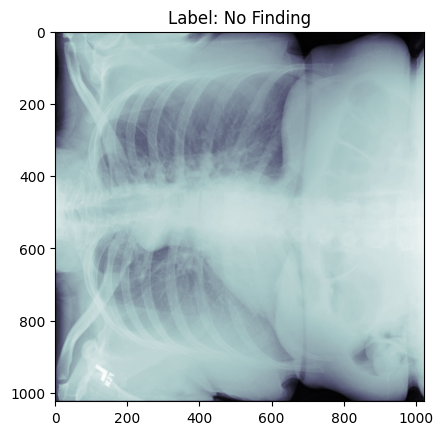

In [156]:
# patient_id = scan._meta["filename_or_obj"].split("/")[-1].split(".")[0]
plt.title(f"Label: {label[0]}")
display_scan = scan.squeeze().numpy()
# display_scan = np.transpose(display_scan, (1, 2, 0))
plt.imshow(display_scan, cmap="bone");

# Using `RTK`

In [ ]:
from omegaconf import DictConfig
import logging

# rtk
from rtk import datasets
from rtk.utils import hydra_instantiate

logging.getLogger("rtk.datasets").setLevel(logging.DEBUG)

dataset = datasets.instantiate_image_dataset(
    cfg=cfg, save_metadata=True
)
train_dataset, test_dataset = dataset[0], dataset[1]

In [ ]:
train_dataset[0][0].shape

In [ ]:
train_loader = hydra_instantiate(
    cfg=dataset_cfg.dataloader,
    dataset=train_dataset,
    pin_memory=torch.cuda.is_available(),
    shuffle=True,
)
test_loader = hydra_instantiate(
    cfg=dataset_cfg.dataloader,
    dataset=test_dataset,
    pin_memory=torch.cuda.is_available(),
)
iterator = iter(train_loader)


## Get some samples

In [ ]:
scan, label = next(iterator)
scan.shape, label

In [ ]:
_filename = scan[10]._meta['filename_or_obj'].split('/')[-1]
patient_id = _filename.split('.')[0]
patient_id

In [ ]:
plt.title(f"Patient ID: {patient_id}")
display_scan = scan[0].numpy()
display_scan = np.transpose(display_scan, (1, 2, 0))
plt.imshow(display_scan, cmap="bone");

In [ ]:
scan, label = datasets.visualize_scan(iterator=iterator)

# Pediatrics age overlap

In [ ]:
pneumonia = "Pneumonia"
ped = patient_df[patient_df[target].str.contains(pneumonia)]


ped[ped["Patient Age"] < 18]

In [ ]:
print(f"Number of patients with {pneumonia}:", len(ped))
print(f"Number of patients with {pneumonia} and age < 18:", len(ped[ped["Patient Age"] < 18]))
print(f"Number of patients with {pneumonia} and age < 21:", len(ped[ped["Patient Age"] < 21]))